## Use of the Python xarray Package

The `xarray` package provides for handling of N-dimensional datasets as numpy arrays, but with each axis dimension labelled for mnemonic access and enhanced broadcasting. For more information see the xarray documentation at https://xarray.pydata.org/en/stable/

The package `astropy` offers a similar data type, but `xarray` is preferred in `MORTICIA` for a number of reasons, including the strong relationship and interaction with `pandas`. For processing of large arrays that do not fit into memory, `xarray` supports the use of the `dask` package for parallel computation.

However, note that `astropy` is used for earth coordinate transformations and celestial body calculations in `MORTICIA`.

In [1]:
import numpy as np
import pandas as pd
import xarray as xray
xD = xray.DataArray
import matplotlib.pyplot as plt
import scipy.interpolate
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity
def U_(units):
    return Q_(1.0, units)
%matplotlib inline
from morticia.tools.xd import *
%matplotlib inline
%load_ext autoreload
%aimport morticia.tools.xd
%autoreload 1

In [2]:
# Build a spectral transmission curve with an xray.DataArray object
# The first paramter is the transmission data, followed by a list of tuples providing the coordinate axes
# In this case there is only the wavelength axis, for which the abbreviation 'wvl' is used
# Attributes for the axis are provided in a dictionary, according to NetCDF conventions and CF conventions
# where appropriate
spec_trans = xray.DataArray([ 0.0, 0.1, 0.3, 0.5, 0.7, 1.0, 1.0, 0.8, 0.0],                      
                   [('wvl', [550., 600, 650, 700, 750, 800, 850, 950, 1000], {'units': 'nm', 'long_name': 'Wavelength'})], 
                   name='trn',
                   attrs={'units': '', 'long_name': 'Transmission'})

# It is also possible to create an "identity" DataArray in which the coordinates are just indices
spatial_frequencies = xray.DataArray(np.linspace(0.0, 1000.0, 11), name='spf', attrs={'units': 'cy/mm'})

In [35]:
spec_trans.wvl.units

'nm'

In [36]:
# Attributes can be accessed using .long_name syntax for reading, but not for writing
spec_trans['wvl'].long_name

'Wavelength'

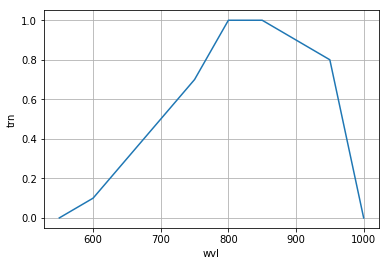

In [4]:
# Coordinate axis names are used to plot the data
spec_trans.plot()
plt.grid()

In [37]:
# Get values of a coordinate axis by name
spec_trans.coords['wvl']

<xarray.DataArray 'wvl' (wvl: 9)>
array([  550.,   600.,   650.,   700.,   750.,   800.,   850.,   950.,  1000.])
Coordinates:
  * wvl      (wvl) float64 550.0 600.0 650.0 700.0 750.0 800.0 850.0 950.0 1e+03
Attributes:
    units:      nm
    long_name:  Wavelength

In [38]:
# Determin the coordinate axes (dimensions) of the spectral transmission (wavelength only)
spec_trans.dims

('wvl',)

In [39]:
# For reading attributes, there are two available routes
print spec_trans.attrs['long_name'], ' or ... '
print spec_trans.long_name


Transmission  or ... 
Transmission


In [40]:
# Create a new wavelength grid
wvl = xray.DataArray(np.linspace(500., 1050, 51), name='wvl', attrs={'units': 'nm'})

In [41]:
wvl


<xarray.DataArray 'wvl' (dim_0: 51)>
array([  500.,   511.,   522.,   533.,   544.,   555.,   566.,   577.,   588.,
         599.,   610.,   621.,   632.,   643.,   654.,   665.,   676.,   687.,
         698.,   709.,   720.,   731.,   742.,   753.,   764.,   775.,   786.,
         797.,   808.,   819.,   830.,   841.,   852.,   863.,   874.,   885.,
         896.,   907.,   918.,   929.,   940.,   951.,   962.,   973.,   984.,
         995.,  1006.,  1017.,  1028.,  1039.,  1050.])
Dimensions without coordinates: dim_0
Attributes:
    units:    nm

In [42]:
# Here we have a transmission DataArray for 2 lens systems, labelled A and B
trans = xray.DataArray([[ 0.0, 0.1, 0.3, 0.5, 0.7, 1.0, 1.0, 0.8, 0.0],
                             [ 0.0, 0.2, 0.5, 0.7, 0.72, 0.7, 0.7, 0.6, 0.5]],                      
                   [('idn', ['A', 'B']),
                    ('wvl', [550., 600, 650, 700, 750, 800, 850, 950, 1000], {'units': 'nm'})], 
                   name='trn',
                   attrs={'units': '', 'extrap_val': 0.0})

In [43]:
trans.wvl

<xarray.DataArray 'wvl' (wvl: 9)>
array([  550.,   600.,   650.,   700.,   750.,   800.,   850.,   950.,  1000.])
Coordinates:
  * wvl      (wvl) float64 550.0 600.0 650.0 700.0 750.0 800.0 850.0 950.0 1e+03
Attributes:
    units:    nm

In [11]:
# Trapzoidal integration of an xray DataArray along a named axis
# However, this returns a regular numpy array integrated along the named axis
np.trapz(trans, axis=trans.get_axis_num('wvl'))

array([ 4.4 ,  4.37])

In [20]:
trans

<xarray.DataArray 'trn' (idn: 2, wvl: 9)>
array([[ 0.  ,  0.1 ,  0.3 ,  0.5 ,  0.7 ,  1.  ,  1.  ,  0.8 ,  0.  ],
       [ 0.  ,  0.2 ,  0.5 ,  0.7 ,  0.72,  0.7 ,  0.7 ,  0.6 ,  0.5 ]])
Coordinates:
  * idn      (idn) |S1 'A' 'B'
  * wvl      (wvl) float64 550.0 600.0 650.0 700.0 750.0 800.0 850.0 950.0 1e+03
Attributes:
    units:       
    extrap_val:  0.0

In [44]:
# Latter integration result is wrong because we failed to take into account the actual coordinates
# in the wavelength axis, so here we do the integration again, using the wavelength values
# as a further input
# Read the following statement as "Perform trapezoidal integration of the DataArray 'trans' along the axis named 'wvl'"
np.trapz(trans, trans['wvl'], axis=trans.get_axis_num('wvl'))

array([ 265.,  251.])

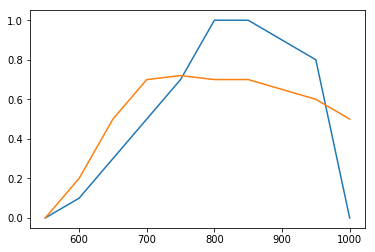

In [45]:
plt.plot(trans['wvl'], trans.loc['A'], trans['wvl'], trans.loc['B'])

In [46]:
# Index into the data using loc
trans.loc['A']

<xarray.DataArray 'trn' (wvl: 9)>
array([ 0. ,  0.1,  0.3,  0.5,  0.7,  1. ,  1. ,  0.8,  0. ])
Coordinates:
    idn      |S1 'A'
  * wvl      (wvl) float64 550.0 600.0 650.0 700.0 750.0 800.0 850.0 950.0 1e+03
Attributes:
    units:       
    extrap_val:  0.0

In [47]:
# Attributes in the attrs dictionary turn up as top-level attributes
trans.wvl.units

'nm'

In [48]:
# Replacement of axis data
spec_trans['wvl'] = np.array([1.,2,3,4,5,6,7,8,9])

In [49]:
spec_trans

<xarray.DataArray 'trn' (wvl: 9)>
array([ 0. ,  0.1,  0.3,  0.5,  0.7,  1. ,  1. ,  0.8,  0. ])
Coordinates:
  * wvl      (wvl) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
Attributes:
    units:      
    long_name:  Transmission

In [51]:
xd_check_convert_units(spec_trans, 'wvl', 'nm')

In [48]:
from morticia.sensor import optics
import xarray
# This notebook is used for development/testing of the Optics module, so auto reload the Optics module if it changes
%load_ext autoreload
%aimport morticia.sensor.optics
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Here, we show the product of two transmission functions defined on different wavelength grids
spec_transA = xray.DataArray([ 0.0, 0.1, 0.3, 0.5, 0.7, 1.0, 1.0, 0.8, 0.0],                      
                   [('wvl', [550., 600, 650, 700, 750, 800, 850, 950, 1000], {'units': 'nm', 'long_name': 'Wavelength'})], 
                   name='trn',
                   attrs={'units': '1', 'extrap_val': 0.0})
spec_transB = xray.DataArray([ 0.0, 0.5, 0.3, 0.25, 0.4, 0.45, 0.6, 0.7],                      
                   [('wvl', [551., 600, 660, 715, 755, 845, 851, 956], {'units': 'nm', 'long_name': 'Wavelength'})], 
                   name='trn',
                   attrs={'units': '1', 'extrap_val': 0.0})

In [4]:
# Look at what the xray.DataArray objects look like with harmonised wavelength grids 
xd_harmonise_interp((spec_transA, spec_transB))

[<xarray.DataArray 'trn' (wvl: 16)>
 array([ 0.   ,  0.002,  0.1  ,  0.3  ,  0.34 ,  0.5  ,  0.56 ,  0.7  ,  0.73 ,
         1.   ,  1.   ,  1.   ,  0.998,  0.8  ,  0.704,  0.   ])
 Coordinates:
   * wvl      (wvl) float64 550.0 551.0 600.0 650.0 660.0 700.0 715.0 750.0 ...
 Attributes:
     units:       1
     extrap_val:  0.0, <xarray.DataArray 'trn' (wvl: 16)>
 array([ 0.      ,  0.      ,  0.5     ,  0.333333,  0.3     ,  0.263636,
         0.25    ,  0.38125 ,  0.4     ,  0.425   ,  0.45    ,  0.575   ,
         0.6     ,  0.694286,  0.7     ,  0.      ])
 Coordinates:
   * wvl      (wvl) float64 550.0 551.0 600.0 650.0 660.0 700.0 715.0 750.0 ...
 Attributes:
     units:       1
     extrap_val:  0.0]

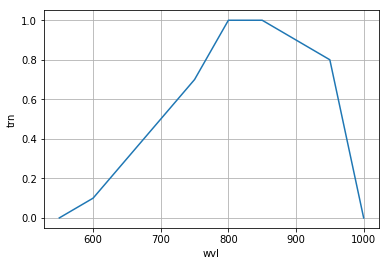

In [5]:
# Plot the A transmission curve
spec_transA.plot()
plt.grid()

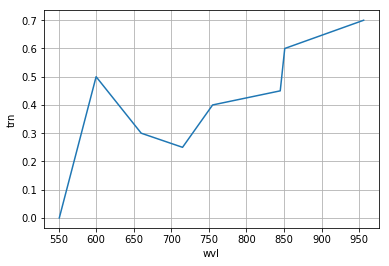

In [6]:
# Plot the B transmission curve
spec_transB.plot()
plt.grid()

In [7]:
# Get the axis-harmonised product
spec_transC = xd_harmonised_product([spec_transA, spec_transB])

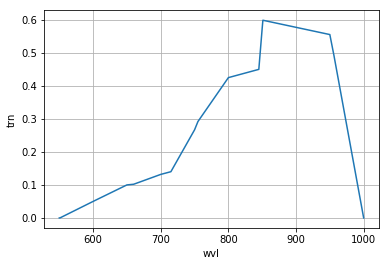

In [8]:
# Plot the product of the two transmission curves
spec_transC.plot()
plt.grid()

In [9]:
spec_transC.wvl.units

'nm'

In [36]:
spec_trans_nan = xray.DataArray(np.ones(9)*np.nan,                      
                   [('wvl', [550., 600, 650, 700, 750, 800, 850, 950, 1000], {'units': 'nm', 'long_name': 'Wavelength'})], 
                   name='trn',
                   attrs={'units': '1', 'extrap_val': 0.0})

In [38]:
spec_trans_nan

<xarray.DataArray 'trn' (wvl: 9)>
array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])
Coordinates:
  * wvl      (wvl) float64 550.0 600.0 650.0 700.0 750.0 800.0 850.0 950.0 1e+03
Attributes:
    units:       1
    extrap_val:  0.0

In [39]:
f3 = BasisFunction(spec_trans_nan)

In [41]:
print f3

<xarray.DataArray 'trn' (wvl: 9)>
array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])
Coordinates:
  * wvl      (wvl) float64 550.0 600.0 650.0 700.0 750.0 800.0 850.0 950.0 1e+03
Attributes:
    units:       1
    extrap_val:  0.0


In [15]:
def add(a,b):
    return a + b

In [17]:
add(1,2, **x)

3

In [18]:
spec_trans

<xarray.DataArray 'trn' (wvl: 9)>
array([ 0. ,  0.1,  0.3,  0.5,  0.7,  1. ,  1. ,  0.8,  0. ])
Coordinates:
  * wvl      (wvl) float64 550.0 600.0 650.0 700.0 750.0 800.0 850.0 950.0 1e+03
Attributes:
    units:      
    long_name:  Transmission

In [28]:
f1 = BasisFunction(spec_transA, evalBuildParms={'bounds_error': False, 'fill_value': np.nan})
f2 = BasisFunction(spec_transB, evalBuildParms={'bounds_error': False, 'fill_value': np.nan})

In [29]:
print f1, f2

<xarray.DataArray 'trn' (wvl: 9)>
array([ 0. ,  0.1,  0.3,  0.5,  0.7,  1. ,  1. ,  0.8,  0. ])
Coordinates:
  * wvl      (wvl) float64 550.0 600.0 650.0 700.0 750.0 800.0 850.0 950.0 1e+03
Attributes:
    units:       1
    extrap_val:  0.0 <xarray.DataArray 'trn' (wvl: 8)>
array([ 0.  ,  0.5 ,  0.3 ,  0.25,  0.4 ,  0.45,  0.6 ,  0.7 ])
Coordinates:
  * wvl      (wvl) float64 551.0 600.0 660.0 715.0 755.0 845.0 851.0 956.0
Attributes:
    units:       1
    extrap_val:  0.0


In [30]:
f2.samples

<xarray.DataArray 'trn' (wvl: 8)>
array([ 0.  ,  0.5 ,  0.3 ,  0.25,  0.4 ,  0.45,  0.6 ,  0.7 ])
Coordinates:
  * wvl      (wvl) float64 551.0 600.0 660.0 715.0 755.0 845.0 851.0 956.0
Attributes:
    units:       1
    extrap_val:  0.0

In [22]:
f1.samples

<xarray.DataArray 'trn' (wvl: 9)>
array([ 0. ,  0.1,  0.3,  0.5,  0.7,  1. ,  1. ,  0.8,  0. ])
Coordinates:
  * wvl      (wvl) float64 550.0 600.0 650.0 700.0 750.0 800.0 850.0 950.0 1e+03
Attributes:
    units:       1
    extrap_val:  0.0

In [24]:
fb = FunctionalBasis([f1, f2])

TypeError: 'BasisFunction' object has no attribute '__getitem__'

In [143]:
dir(FunctionalBasis)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [155]:
spec_transA[spec_transA.dims[0]].data


array([  550.,   600.,   650.,   700.,   750.,   800.,   850.,   950.,
        1000.])

In [1]:
x = 'default'

In [3]:
x == 'default'

False

In [27]:
np.nans((2,3))

AttributeError: 'module' object has no attribute 'nans'

In [25]:
np.all(np.array([]) == np.nan)

nan

In [42]:
print f3

<xarray.DataArray 'trn' (wvl: 9)>
array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])
Coordinates:
  * wvl      (wvl) float64 550.0 600.0 650.0 700.0 750.0 800.0 850.0 950.0 1e+03
Attributes:
    units:       1
    extrap_val:  0.0


In [47]:
f3 = BasisFunction(spec_trans_nan)

In [48]:
f3()

TypeError: 'BasisFunction' object is not callable